# Data ingestion for vector store
Researches:
* PDF document loaders 
* Chunk strategies
In order to produce optimal embeddings from documents

## Notes on experiment PDF document loaders
- Does not seems that for the images OCR add much value, difficult pictures with a non-common structure.
--> May be better suited for an LLM with multimodal capabilities


### Notes on comparison OCR vs LLM for image parsing
- RapidOCR (~2 min) is much quicker than o4-mini (14 min 03s)
- RapidOCR is much cheaper (free) than o4-mini (51 K tokens, from 38K completion and 13K prompt = 0.1815 $)
- Total request is 69 (approximate total page size of 61 + 7 figures) --> while only 7 'Figures are of maybe interest', additional request because of logo at the top left.
- Pension Federation at the top may also use up considerable resources
- Images description by MUPDF do not always get inserted at the position of the image in the original document, may also be at the end of the page.

- PyMUPDF4LLM (9min 47s with o4-mini)

### PYPDF with standard config

In [1]:
import os

FILE_PATH_TO_EMBED = os.path.join("data/raw", "pension-martijn-files", "Kader Datakwaliteit - wet toekomst pensioenen.pdf.pdf")
DIRECTORY_TO_EMBED = os.path.join("data", "raw", "pension-martijn-files")


In [2]:
import warnings
import os

# load pdf
# from langchain_community.document_loaders import PyPDFLoader
# loader = PyPDFLoader(FILE_PATH_TO_EMBED)

# load directory of PDFs
from langchain_community.document_loaders import PyPDFDirectoryLoader
loader = PyPDFDirectoryLoader(DIRECTORY_TO_EMBED)

pages = []
async for page in loader.alazy_load():
    pages.append(page)


print(f"LOADED DOCUMENT WITH {len(pages)} PAGES")
if len(pages) > 50:
    warnings.warn("DOCUMENT PAGES LOADED IN IS LARGE THAN 100, MAY INCUR SIGNIFICANT COSTS")


for page in pages:
    if page.page_content == None or page.page_content == "":
        warnings.warn("FOUND PAGES IN DOCUMENT WITHOUT PAGE_CONTENT")

LOADED DOCUMENT WITH 69 PAGES


C:\Users\bvbraak\AppData\Local\Temp\ipykernel_11668\3214218585.py:19: UserWarning: DOCUMENT PAGES LOADED IN IS LARGE THAN 100, MAY INCUR SIGNIFICANT COSTS
  warnings.warn("DOCUMENT PAGES LOADED IN IS LARGE THAN 100, MAY INCUR SIGNIFICANT COSTS")


Identified issues
1. footnotes
2. neemt geen figuren mee
3. tabellen, verliest structuur
4. links worden niet meegenomen
5. verlies van layout en structuur, belangrijk met titels, artikelen etc.
6. wordt opgesplist in pagina's, maar is niet altijd logisch einde, miss beter per sectie.

### PyMuPDF with image parser and extract tables

In [3]:
from dotenv import load_dotenv
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_openai import AzureChatOpenAI
from langchain_community.document_loaders.parsers.images import TesseractBlobParser, RapidOCRBlobParser, LLMImageBlobParser


load_dotenv()
# tesseract not downloaded yet as need to install executable by system admin
# images_parser = TesseractBlobParser(langs=('nld',))
# images_parser = RapidOCRBlobParser()
# model = ChatGoogleGenerativeAI(model="model/gemini-2.5-pro-exp-03-25") #did not test this one yet
model = AzureChatOpenAI(
        model="o4-mini",
        azure_endpoint=os.environ["AZURE_OPENAI_ENDPOINT_SWEDEN"],
        api_version="2025-01-01-preview",
        api_key=os.environ["AZURE_OPENAI_API_KEY_SWEDEN"]
    )
print(model)

# from packages
prompt: str = (
    "You are an assistant tasked with summarizing images for retrieval. "
    "1. These summaries will be embedded and used to retrieve the raw image. "
    "Give a concise summary of the image that is well optimized for retrieval\n"
    "2. extract all the text from the image. "
    "Do not exclude any content from the page.\n"
    "Return your answer in plain text"
)

images_parser = LLMImageBlobParser(model=model, prompt=prompt)

client=<openai.resources.chat.completions.completions.Completions object at 0x000002102A8A92B0> async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x000002102A8B9A90> root_client=<openai.lib.azure.AzureOpenAI object at 0x000002102A6AECF0> root_async_client=<openai.lib.azure.AsyncAzureOpenAI object at 0x000002102A8A9400> model_name='o4-mini' model_kwargs={} openai_api_key=SecretStr('**********') disabled_params={'parallel_tool_calls': None} azure_endpoint='https://openai-playground-bjorn-sweden.openai.azure.com' openai_api_version='2025-01-01-preview' openai_api_type='azure'


In [ ]:

from langchain_community.document_loaders import PyMuPDFLoader

# testing loader on entire filepath
loader = PyMuPDFLoader(FILE_PATH_TO_EMBED, extract_images=True, images_parser=images_parser, extract_tables="markdown" )

pages = []
async for page in loader.alazy_load():
    pages.append(page)

client=<openai.resources.chat.completions.completions.Completions object at 0x0000027927C76AD0> async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x0000027927C7AE90> root_client=<openai.lib.azure.AzureOpenAI object at 0x00000279279EA490> root_async_client=<openai.lib.azure.AsyncAzureOpenAI object at 0x0000027927C76C10> model_name='o4-mini' model_kwargs={} openai_api_key=SecretStr('**********') disabled_params={'parallel_tool_calls': None} azure_endpoint='https://openai-playground-bjorn-sweden.openai.azure.com' openai_api_version='2025-01-01-preview' openai_api_type='azure'


Early identified issue with PyPDF, now partly resolved with PyMuPDF:
1. footnotes --> unresolved
2. neemt geen figuren mee --> Improved with LLM for image_parsing
3. tabellen, verliest structuur --> improved with PyMuPDF
4. links worden niet meegenomen --> unresolved (may not be as important)
5. verlies van layout en structuur, belangrijk met titels, artikelen etc. --> unresolved
6. wordt opgesplist in pagina's, maar is niet altijd logisch einde, miss beter per sectie. --> unresolved (may be a langchain issue not investigated yet)

### PyMuPDF4LLM with image_parser and extract tables AND returning markdown
on single mode and page mode ~ 25s without image parsing


In [5]:
from langchain_pymupdf4llm import PyMuPDF4LLMLoader

# https://pymupdf.readthedocs.io/en/latest/page.html#Page.find_tables
# Request a table detection strategy. Valid values are “lines”, “lines_strict” and “text”.
# Default is “lines” which uses all vector graphics on the page to detect grid lines.
# Strategy “lines_strict” ignores borderless rectangle vector graphics. Sometimes single text pieces have background colors which may lead to false columns or lines. This strategy ignores them and can thus increase detection precision.
# If “text” is specified, text positions are used to generate “virtual” column and / or row boundaries. Use min_words_* to request the number of words for considering their coordinates.
# Use parameters vertical_strategy and horizontal_strategy instead for a more fine-grained treatment of the dimensions.

# DEBUG_FILE_PATH_TO_EMBED = os.path.join("data/raw/pension-martijn-files-debugging", "10-page-data-kwaliteit.pdf")
# DEBUG_DIRECTORY_TO_EMBED = os.path.join("data/raw/pension-martijn-files-debugging")
#PyMuPDF4LLMLoader(DEBUG_FILE_PATH_TO_EMBED, mode="single", extract_images=True, images_parser=images_parser, table_strategy="lines_strict")

documents = {}
# loading files synchronously, may benefit from doing this asynchronous later
directory = DIRECTORY_TO_EMBED
for file_name in os.listdir(directory):
    print(f"LOADING DOCUMENT {file_name}...")
    file_path_to_embed = os.path.join(directory, file_name)
    loader = PyMuPDF4LLMLoader(file_path_to_embed, mode="single", extract_images=True, images_parser=images_parser, table_strategy="lines_strict") 

    pages = []
    async for page in loader.alazy_load():
        pages.append(page)

    print(f"FINISHED LOADING DOCUMENT {file_name}: {len(pages)}")
    documents[file_name] = pages


print(f"FINISHED LOADING: {len(documents)}")

LOADING DOCUMENT Kader Datakwaliteit - wet toekomst pensioenen.pdf.pdf...
FINISHED LOADING DOCUMENT Kader Datakwaliteit - wet toekomst pensioenen.pdf.pdf: 1
LOADING DOCUMENT pensioenregelement 2018 Stichting Pensioenfonds Rockwool bv.pdf...
FINISHED LOADING DOCUMENT pensioenregelement 2018 Stichting Pensioenfonds Rockwool bv.pdf: 1
LOADING DOCUMENT pensioenregelement Stichting Pensioenfonds van De Nederlandsche Bank NV.pdf...
FINISHED LOADING DOCUMENT pensioenregelement Stichting Pensioenfonds van De Nederlandsche Bank NV.pdf: 1
FINISHED LOADING: 3


Early identified issue with PyPDF, partly resolved with PyMuPDF, and PyMuPDF4LLM:
1. footnotes included, but not inserted at place of footnote, but where they are located (so llm will not understand) --> unresolved
2. neemt geen figuren mee -->  [PyMuPDF] Improved with LLM for image_parsing
3. tabellen, verliest structuur --> [PyMuPDF] Improved with PyMuPDF
4. links worden niet meegenomen --> [PyMuPDF4LLM] Resolved with markdown formatting
5. verlies van layout en structuur, belangrijk met titels, artikelen etc. --> unresolved --> [PyMuPDF4LLM] Improved with markdown formatting
6. wordt opgesplist in pagina's, maar is niet altijd logisch einde, miss beter per sectie. --> [PyMuPDF] mode='single'

Test concluded:
The test were performed one pdf, namely Kader Datakwaliteit - wet toekomst pensioenen.pdf.
Based on the experiment issues were identified with converting pdf to raw text. Fix all identified issues excluding footnote, which is not the most important issue to focus on as likely adds little value.

Future direction:

Interesting parser may be, which also let's you parse different types of documents, now the pipeline only handles .pdfs
* https://www.llamaindex.ai/llamaparse
* https://unstructured.io/

In addition significant speed up by just remove logo on the top left in document (repeating information)

### notes on small technical change
small technical problem when using a markdown header splitter, e.g.
images distort the headers, so should not give markdown format within image description:

![## Summary Logo for “Pensioen Federatie” featuring the organization’s name in uppercase letters with stylized golden arcs.

Extracted Text
PENSIOEN
FEDERATIE](#)

#### IMPLEMENTED CHANGE
Slightly adjusted the instruction for llm-based image_parser to not return plain text

In [6]:
# save pdf documents which are transformed in markdown format with mode = "single" to seperate files 
for file_name, pages in documents.items():
    if len(pages) == 1: #only for single pages returned
        document = pages[0] #very prone to bugs, must be a better way
    else:
        raise Exception("not implemented yet")
    
    with open(os.path.join("data/preprocessed/pension-martijn-files", file_name + ".md"), 'w', encoding='utf-8') as f:
        f.write(document.page_content)

In [24]:
def print_document_page(page):
    correction_index = 1 #differ per pdf converter, also have different metadata
    print(f"--- source {page.metadata["source"].split("\\")[-1]} ---")
    print(f"--- page {page.metadata["page"] + correction_index} / {page.metadata["total_pages"]} ---")
    print(page)
    print("---end of page")


# for page in pages[:61]:
#     print_document_page(page)

# for page in pages[61:105]:
#     print_document_page(page)

# for page in pages[105:]:
#     print_document_page(page)

## Notes on chunking strategy
### Markdown formatting not preserved by MarkdownTextSplitter
#### Resolution
Switched from MarkdownTextSplitter
to 
ExperimentalMarkdownSyntaxTextSplitter

main reason was newlines were removed within the markdown for no apperent reason,
which broke formatting e.g. with

42

----

becoming

This is a all bold
42
-----

Which is just \n characters which are removed from the original file

```
This is a all bold
42
-----
```

### Table being cut in middle of chunk
* Additionally I had problems with tables getting cut of, not sure if resolved yet, e.g. if it is recusrivetextsplitter problem, markdowntextsplitter, or combination.


### Multipage table not being interpret correct through the markdown
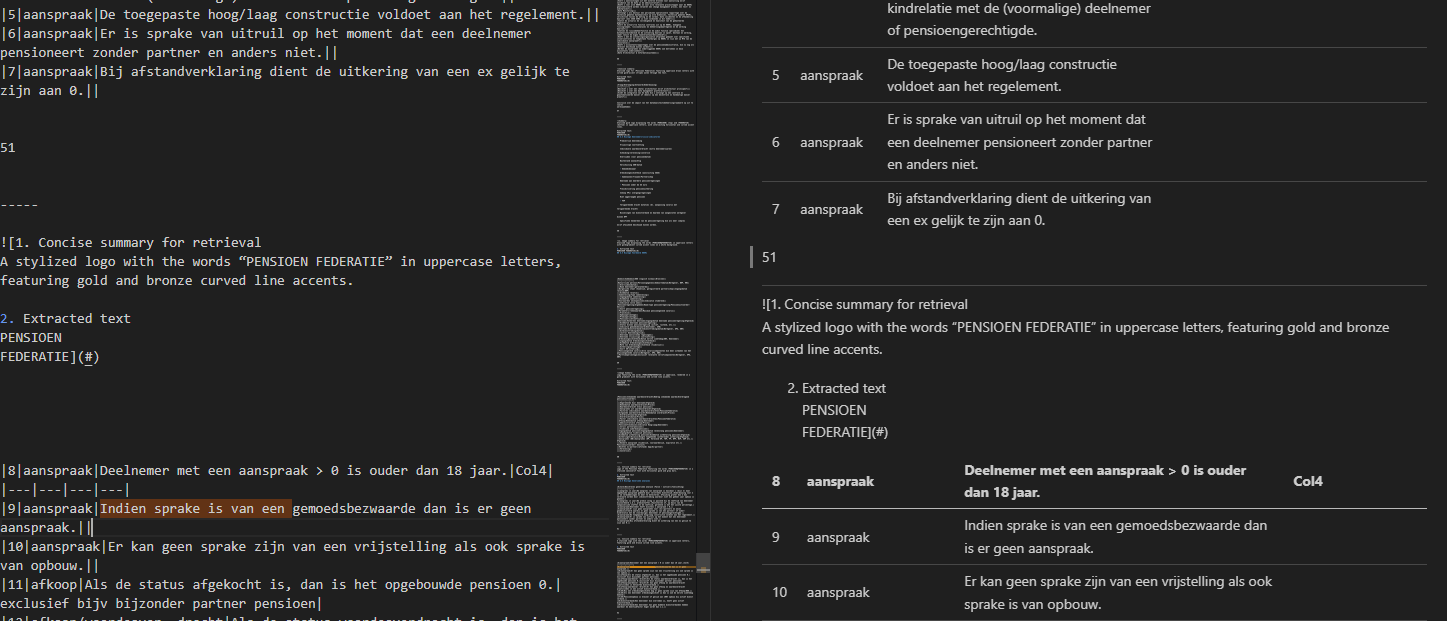

### Textsplitters

#### Using basic textsplitter on pagened documents

In [ ]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

print(f"DOCUMENT WITH {len(pages)} PAGES")
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,   # Each chunk will be 1000 characters
    chunk_overlap=100  # Overlap of 100 characters between chunks
)

split_pages = text_splitter.transform_documents(pages)

print(f"NUMBER OF CHUNKS: {len(split_pages)}")

#### Using markdown textsplitter on single document

In [33]:
from langchain_text_splitters.markdown import ExperimentalMarkdownSyntaxTextSplitter

# with open(os.path.join("./experiment-output", "pypdf4llm-on-data-quality-output-SINGLE-v2.md"), 'r', encoding='utf-8') as f:
#     markdown_file = f.read()

headers_to_split_on = [
    ("#", "Header 1"),
    ("##", "Header 2"),
    ("###", "Header 3"),
]

DIRECTORY_TO_EMBED_V2 = os.path.join("data/preprocessed/pension-martijn-files")

directory = DIRECTORY_TO_EMBED_V2
all_markdown_splits = []
for file_name in os.listdir(directory):
    with open(os.path.join(directory, file_name), 'r', encoding='utf-8') as f:
        markdown_file = f.read()
        markdown_splits = ExperimentalMarkdownSyntaxTextSplitter(headers_to_split_on=headers_to_split_on).split_text(markdown_file)
        all_markdown_splits.extend(markdown_splits)

### bug report on rockwool markdown splitting:
the file does was not converted into a proper markdown heading,
will leave for now as tomorrow is the demo

In [34]:
print(len(all_markdown_splits))
for s in all_markdown_splits:
    print(s.metadata)
    print(s.page_content)

175
{}
![Concise summary:
Pensioenfederatie contact details card with address in Den Haag, phone number, email, website, and KvK number.

Extracted text:
Pensioenfederatie
Prinses Margrietplantsoen 90
2595 BR Den Haag
Postbus 93158
2509 AD Den Haag
T +31 (0)70 76 20 220
info@pensioenfederatie.nl
www.pensioenfederatie.nl

KvK Haaglanden 52988368](#)









![1. Concise summary for retrieval  
A gold‑gradient corporate logo displaying a stylized “P” and “F” alongside the words “Pensioen Federatie.”

2. Extracted text  
PENSIOEN  
FEDERATIE](#)

DATUM: 11 oktober 2022

ONDERWERP: Kader Datakwaliteit

KENMERK: D/2022/718/OH

{'Header 1': 'Kader Datakwaliteit –  Wet Toekomst Pensioenen'}

![1. Concise summary for retrieval  
“Logo of Pensioen Federatie—stylized uppercase gold lettering with curved accent lines.”

2. Extracted text  
PENSIOEN  
FEDERATIE](#)

{'Header 1': 'Kader Datakwaliteit –  Wet Toekomst Pensioenen', 'Header 2': 'Inhoudsopgave'}

1. INLEIDING KADER DATAKWALITEIT 4

2. 

In [24]:
print(len(all_markdown_splits))
for s in all_markdown_splits:
    print(s.metadata)
    print(s.page_content)

58
{}
![Concise summary:
Pensioenfederatie contact details card with address in Den Haag, phone number, email, website, and KvK number.  
Extracted text:
Pensioenfederatie
Prinses Margrietplantsoen 90
2595 BR Den Haag
Postbus 93158
2509 AD Den Haag
T +31 (0)70 76 20 220
info@pensioenfederatie.nl
www.pensioenfederatie.nl  
KvK Haaglanden 52988368](#)  
![1. Concise summary for retrieval
A gold‑gradient corporate logo displaying a stylized “P” and “F” alongside the words “Pensioen Federatie.”  
2. Extracted text
PENSIOEN
FEDERATIE](#)  
DATUM: 11 oktober 2022  
ONDERWERP: Kader Datakwaliteit  
KENMERK: D/2022/718/OH
{'Header 1': 'Kader Datakwaliteit –  Wet Toekomst Pensioenen'}
-----  
![1. Concise summary for retrieval
“Logo of Pensioen Federatie—stylized uppercase gold lettering with curved accent lines.”  
2. Extracted text
PENSIOEN
FEDERATIE](#)
{'Header 1': 'Kader Datakwaliteit –  Wet Toekomst Pensioenen', 'Header 2': 'Inhoudsopgave'}
1. INLEIDING KADER DATAKWALITEIT 4  
2. OVERZICH

In [32]:
type(markdown_splits[1])
print(markdown_splits[31].__dict__)

{'id': None, 'metadata': {'Header 1': 'Pensioenregeling van Stichting Pensioenfonds van De Nederlandsche Bank NV', 'Header 2': '**Artikel 28 Inwerkingtreding en benaming **'}, 'page_content': 'Dit reglement kan worden aangehaald als “Pensioenreglement 2021” en is door het\nbestuur van het Fonds vastgesteld per 1 januari 2021 en laatstelijk door het bestuur\ngewijzigd per 1 januari 2025, in zijn vergadering <datum> januari 2025.  \nArtikel 27 (Hardheidsclausule) treedt met terugwerkende kracht in werking vanaf\n1 januari 2024.  \nR.H.A. van Vledder P. de Groot  \nvoorzitter secretaris  \n43  \n-----', 'type': 'Document'}


In [35]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,   # Each chunk will be 1000 characters
    chunk_overlap=100  # Overlap of 100 characters between chunks
)

chunks = text_splitter.transform_documents(all_markdown_splits)

In [ ]:
print(len(all_markdown_splits))
print(len(chunks))

175
464


In [37]:
def print_chunk(chunk, headers_to_split_on):
    headers = []
    for key, value in chunk.metadata.items():
        header = ": ".join([key, value])
        headers.append(header)

    print("=== start of chunk === ")
    print(f"--- source ---")
    print(f"#{"\n#".join(headers)}")
    print("--- end of source ---")
    # print(f"--- page {page.metadata["page"] + correction_index} / {page.metadata["total_pages"]} ---")
    print(chunk)
    print("=== end of chunk ===")

for chunk in chunks:
    print_chunk(chunk, headers_to_split_on)

=== start of chunk === 
--- source ---
#
--- end of source ---
page_content='![Concise summary:
Pensioenfederatie contact details card with address in Den Haag, phone number, email, website, and KvK number.

Extracted text:
Pensioenfederatie
Prinses Margrietplantsoen 90
2595 BR Den Haag
Postbus 93158
2509 AD Den Haag
T +31 (0)70 76 20 220
info@pensioenfederatie.nl
www.pensioenfederatie.nl

KvK Haaglanden 52988368](#)









![1. Concise summary for retrieval  
A gold‑gradient corporate logo displaying a stylized “P” and “F” alongside the words “Pensioen Federatie.”

2. Extracted text  
PENSIOEN  
FEDERATIE](#)

DATUM: 11 oktober 2022

ONDERWERP: Kader Datakwaliteit

KENMERK: D/2022/718/OH'
=== end of chunk ===
=== start of chunk === 
--- source ---
#Header 1: Kader Datakwaliteit –  Wet Toekomst Pensioenen
--- end of source ---
page_content='![1. Concise summary for retrieval  
“Logo of Pensioen Federatie—stylized uppercase gold lettering with curved accent lines.”

2. Extracted text 

In [38]:
from langchain_openai import AzureOpenAIEmbeddings
# from langchain_google_genai import GoogleGenerativeAIEmbeddings


# Set your Azure OpenAI credentials
embedding_api_key = os.getenv("AZURE_OPENAI_API_KEY")
# print(api_key)

# Create an AzureOpenAIEmbeddings object
embedding_model = AzureOpenAIEmbeddings(
    model="text-embedding-3-small",
    azure_endpoint="https://openai-playground-bjorn.openai.azure.com/",
    api_version="2023-05-15",
    api_key=embedding_api_key
)

In [39]:
#config
import os
COLLECTION_NAME = "DATA_QUALITY_PENSION_V2.1" #name of the collection
PERSIST_DIRECTORY = os.path.join("data", "vector_stores", "pension-martijn-embeddings")

#os.path.join( "data", "solvency-II-files", "solvency II - level 1 - v2.pdf")

from langchain_chroma import Chroma
vectorstore = Chroma(COLLECTION_NAME, embedding_model, persist_directory=PERSIST_DIRECTORY)
print(vectorstore._collection.count())

from langchain_core.vectorstores import InMemoryVectorStore
from langchain_chroma import Chroma

# In memory vector store for testing only
# vectorstore = InMemoryVectorStore(embedding_model)
# create a database with vector embedding and documents.

# note: behavior of from_documents is to add if vectorstore already exists
delete_vector_store_check = input("Do you want to delete the vector_store before adding these documents?")
if delete_vector_store_check == "Y":
    Chroma.delete_collection(Chroma(COLLECTION_NAME, embedding_model, persist_directory=PERSIST_DIRECTORY))

# Save a new vector store based on config at top of this file (create_vector_store.ipynb)
check = input("Are you sure you want to run this command? Creating a vectorstore will append to the existing vectorstore and may incur high costs (Y/n)")

if check == "Y":
    print("CREATING A NEW VECTOR STORE AT SPECIFIED LOCATION")
    vectorstore = Chroma.from_documents(chunks, embedding_model, collection_name=COLLECTION_NAME, persist_directory=PERSIST_DIRECTORY)
    print(vectorstore._collection.count())

0
CREATING A NEW VECTOR STORE AT SPECIFIED LOCATION
464
